In [1]:
import pandas as pd
extract_path='/kaggle/input/crick1/MV dataset'

In [2]:
import os

# Change the path to a writable directory
extract_path = "/kaggle/working"
video_path = "/kaggle/input/crick1/MV dataset/slog/26_lsg_mi_slog_16.mp4"  # Keep input path same
frames_folder = os.path.join(extract_path, "frames")  # Store frames in Kaggle's working directory

# Create the frames folder in a writable location
os.makedirs(frames_folder, exist_ok=True)

def extract_frames(video_path, frames_folder):
    import cv2
    
    cap = cv2.VideoCapture(video_path)
    count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(frames_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        count += 1

    cap.release()
    print(f"Extracted {count} frames to {frames_folder}")

extract_frames(video_path, frames_folder)


Extracted 24 frames to /kaggle/working/frames



Displaying optical flow frame 0


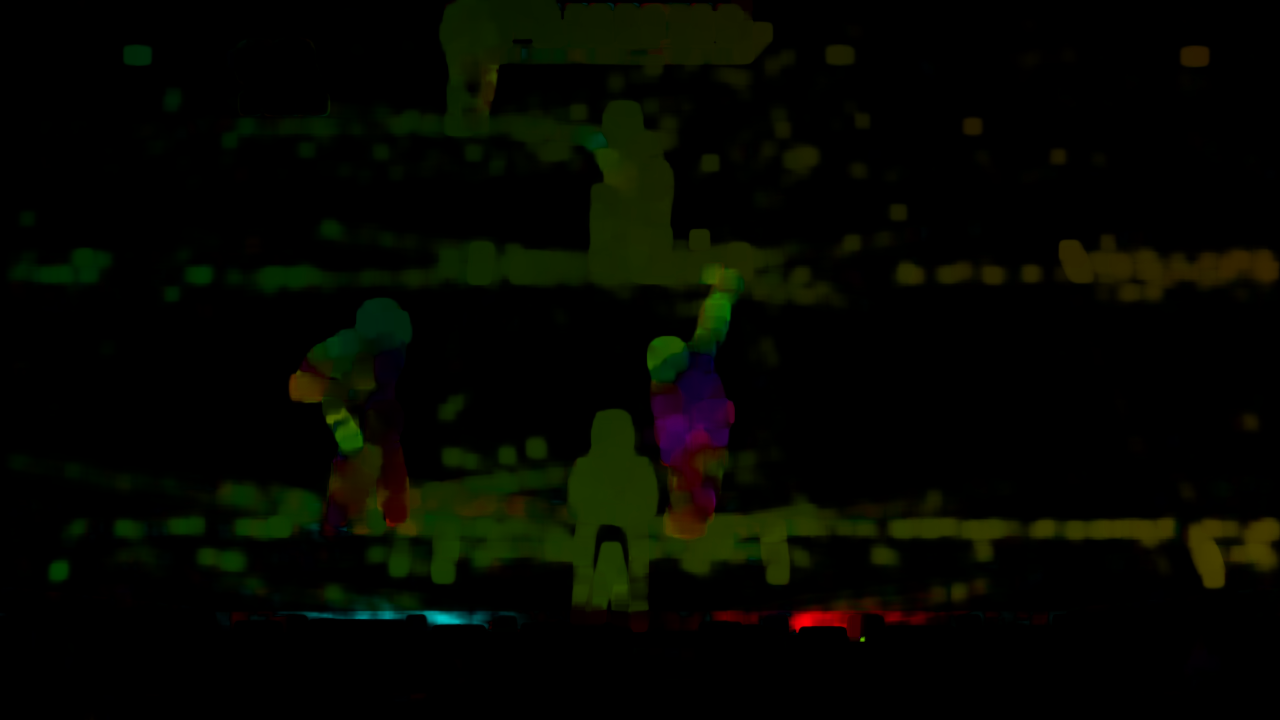

Frame 0: Avg dx: 0.16, Avg dy: 0.89, Avg Magnitude: 1.18, Avg Angle: 120.98°

Displaying optical flow frame 10


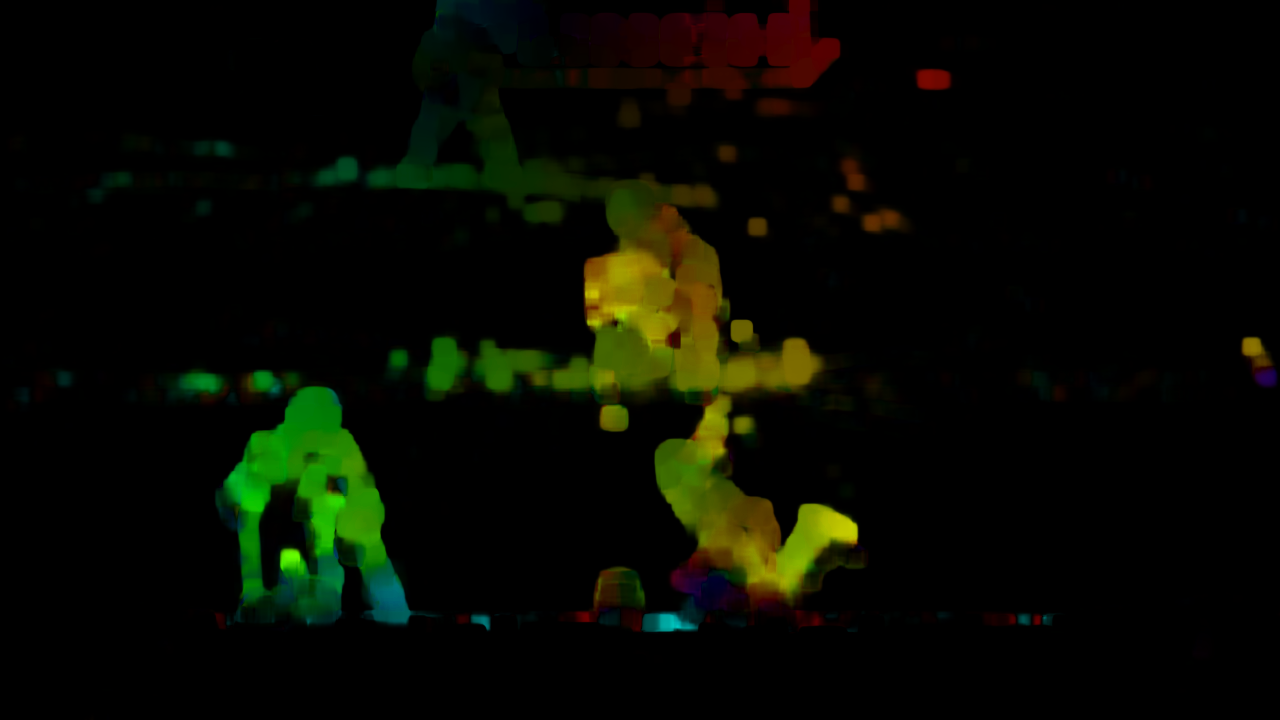

Frame 10: Avg dx: 0.25, Avg dy: 1.30, Avg Magnitude: 1.85, Avg Angle: 155.25°

Displaying optical flow frame 20


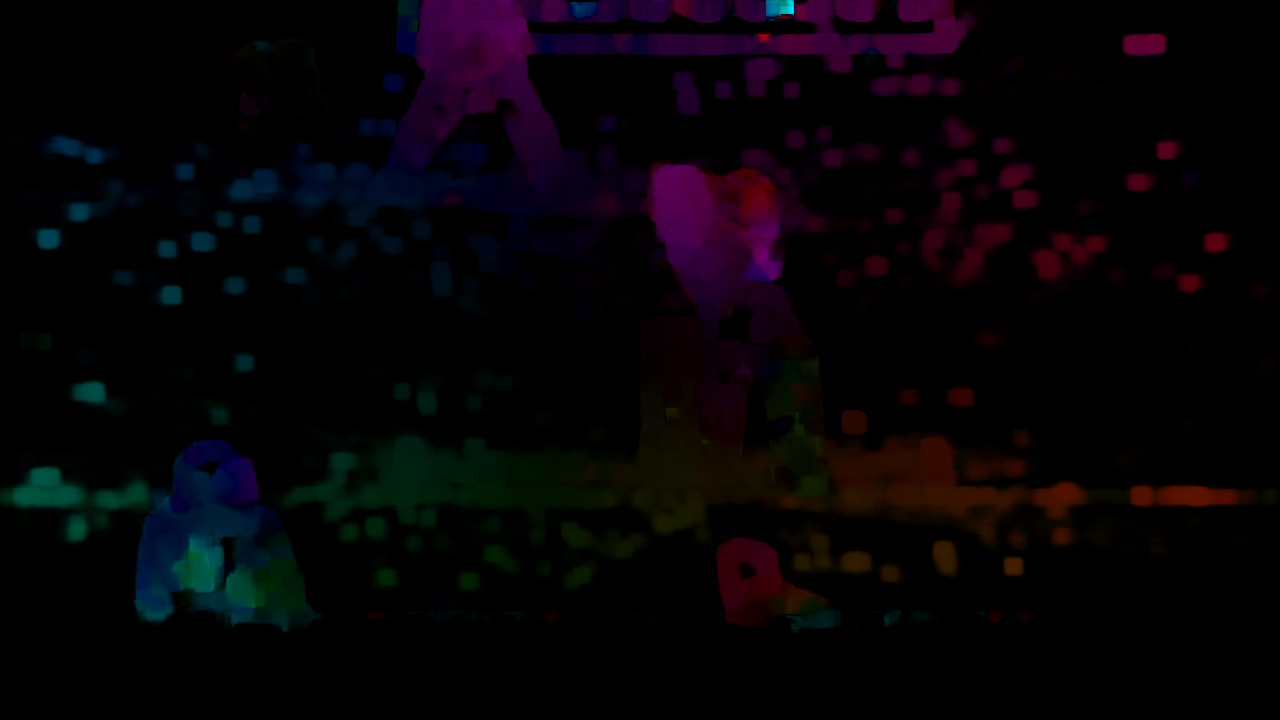

Frame 20: Avg dx: 0.25, Avg dy: -0.53, Avg Magnitude: 1.74, Avg Angle: 192.02°

Optical flow computation completed!


In [3]:
# =========================== STEP 4: Compute Optical Flow ===========================
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

def compute_optical_flow(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Could not read the video file!")
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    frame_count = 0  # Limit display to avoid excessive output in Colab

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Compute optical flow parameters
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])  # Magnitude and angle
        ang_degrees = ang * 180 / np.pi  # Convert angle to degrees

        # Compute motion statistics (average motion values)
        avg_dx = np.mean(flow[..., 0])  # Mean horizontal motion
        avg_dy = np.mean(flow[..., 1])  # Mean vertical motion
        avg_mag = np.mean(mag)         # Mean motion magnitude
        avg_ang = np.mean(ang_degrees) # Mean motion direction in degrees

        # Visualizing the flow
        hsv = np.zeros_like(frame)
        hsv[...,1] = 255
        hsv[...,0] = ang * 180 / np.pi / 2  # Hue represents direction
        hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value represents magnitude
        flow_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        if frame_count % 10 == 0:  # Process every 10th frame to reduce spam
            print(f"\nDisplaying optical flow frame {frame_count}")
            cv2_imshow(flow_image)

            # Print motion statistics instead of per-pixel vectors
            print(f"Frame {frame_count}: Avg dx: {avg_dx:.2f}, Avg dy: {avg_dy:.2f}, "
                  f"Avg Magnitude: {avg_mag:.2f}, Avg Angle: {avg_ang:.2f}°")

        prev_gray = gray
        frame_count += 1

    cap.release()
    print("\nOptical flow computation completed!")

# Example usage
compute_optical_flow(video_path)


In [4]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 15.9 MB/s eta 0:00:00a 0:00:01


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Image loaded successfully!

0: 384x640 4 persons, 90.3ms
Speed: 9.8ms preprocess, 90.3ms inference, 276.2ms postprocess per image at shape (1, 3, 384, 640)


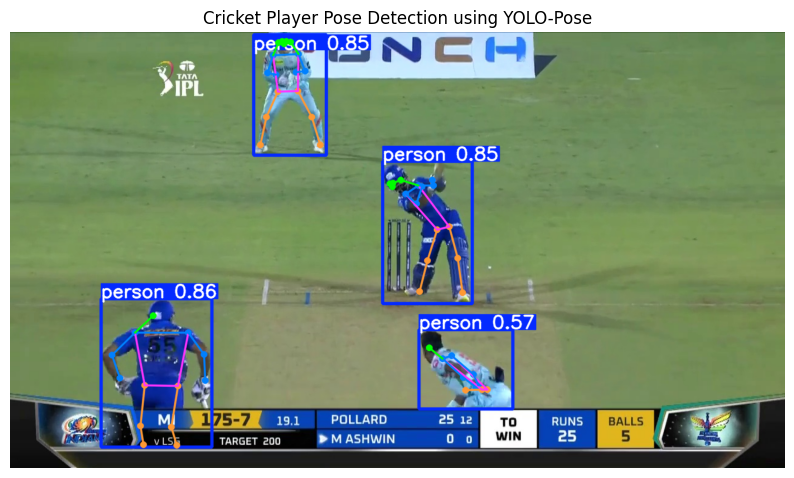

In [5]:
import cv2
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load YOLOv8 Pose Model
model = YOLO("yolov8n-pose.pt")  # Lightweight model (use "yolov8m-pose.pt" for better accuracy)

# Load Cricket Image
image_path = "/kaggle/working/frames/frame_0015.jpg"  # Modify if needed

# Read image
image = cv2.imread(image_path)
if image is None:
    print(f"❌ Error: Unable to read image at {image_path}")
else:
    print("✅ Image loaded successfully!")

# Perform Pose Detection
results = model(image)  # YOLOv8 inference

# Visualize Detected Poses
# Convert image to RGB for Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the first result from the list
pose_result = results[0]  # Access first element

# Draw pose landmarks on the image
pose_image = pose_result.plot()  # Use .plot() instead of .show()

# Display the result using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis("off")
plt.title("Cricket Player Pose Detection using YOLO-Pose")
plt.show()

In [6]:
import os
import shutil
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#✅ Paths
dataset_path = "/kaggle/input/crick1/MV dataset"
train_path = "/kaggle/working/dataset/train/"
test_path = "/kaggle/working/dataset/test/"

# ✅ Ensure Output Directories Exist
for path in [train_path, test_path]:
    os.makedirs(path, exist_ok=True)

In [7]:
# ✅ Get Shot Categories
shot_categories = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
print("✅ Shot Categories:", shot_categories)

✅ Shot Categories: ['pull', 'flick', 'misc', 'cut', 'slog', 'sweep', 'drive']


In [8]:
# ✅ Move Videos to Train & Test Folders (Fixing OSError)
for category in shot_categories:
    video_files = os.listdir(os.path.join(dataset_path, category))
    random.shuffle(video_files)  # Shuffle before splitting

    split_idx = int(0.8 * len(video_files))
    train_videos, test_videos = video_files[:split_idx], video_files[split_idx:]

    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)

    for vid in train_videos:
        shutil.copy(os.path.join(dataset_path, category, vid), os.path.join(train_path, category, vid))

    for vid in test_videos:
        shutil.copy(os.path.join(dataset_path, category, vid), os.path.join(test_path, category, vid))

print("✅ Train-Test Split Completed!")

✅ Train-Test Split Completed!


In [9]:
IMG_SIZE = 75
FRAME_COUNT = 20

def extract_frames(video_path):
    """ Extracts frames from a video using OpenCV """
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print(f"⚠️ Cannot open video: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, FRAME_COUNT, dtype=int)

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()

        if not ret or frame is None:
            continue

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame / 255.0)  # Normalize

    cap.release()

    if len(frames) < FRAME_COUNT:
        return None

    return np.array(frames)

In [10]:
# ==================== STEP 3: Load Dataset ====================

X_train, y_train, X_test, y_test = [], [], [], []

label_map = {cls: idx for idx, cls in enumerate(shot_categories)}

# ✅ Load Training Videos
for class_name in shot_categories:
    class_path = os.path.join(train_path, class_name)
    for video in os.listdir(class_path):
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path)
        if frames is not None:
            X_train.append(frames)
            y_train.append(label_map[class_name])

# ✅ Load Testing Videos
for class_name in shot_categories:
    class_path = os.path.join(test_path, class_name)
    for video in os.listdir(class_path):
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path)
        if frames is not None:
            X_test.append(frames)
            y_test.append(label_map[class_name])

# ✅ Convert to NumPy arrays
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = to_categorical(y_train, num_classes=len(shot_categories)), to_categorical(y_test, num_classes=len(shot_categories))

print(f"✅ Data Loaded: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples")


✅ Data Loaded: 1021 train samples, 752 test samples


In [11]:
import cv2

video_path = "/kaggle/input/crick1/MV dataset/flick/10_gt_dc_flick_6.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("❌ Corrupted or unreadable video file!")
else:
    print("✅ Video is fine!")

cap.release()

✅ Video is fine!


In [12]:
import numpy as np
import cv2

def augment_video_numpy(video):
    """ Applies augmentation using OpenCV for each frame """
    augmented_frames = []
    for frame in video:
        if np.random.rand() < 0.5:
            frame = cv2.flip(frame, 1)  # Horizontal flip
        if np.random.rand() < 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            frame = np.clip(frame * brightness, 0, 1)  # Adjust brightness
        augmented_frames.append(frame)
    return np.array(augmented_frames)

# ✅ Apply augmentation BEFORE training
X_train_augmented = np.array([augment_video_numpy(video) for video in X_train])

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling3D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_3d_cnn():
    """ Optimized 3D CNN model for cricket shot classification with proper pooling sizes """
    model = Sequential([
        # ✅ First Conv Layer (DO NOT POOL TIME EARLY)
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding="same", input_shape=(FRAME_COUNT, IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2)),  # ✅ Pool spatial, not temporal

        # ✅ Second Conv Layer
        Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2)),  # ✅ Preserve temporal dimension

        # ✅ Third Conv Layer (Reduce Temporal Here)
        Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),  # ✅ Reduce depth here

        # ✅ Fourth Conv Layer
        Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),

        # ✅ Global Pooling to Avoid Overfitting
        GlobalAveragePooling3D(),

        # ✅ Fully Connected Layers
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(len(shot_categories), activation='softmax')  # Output layer
    ])
    
    model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# ✅ Build Model
model = build_3d_cnn()
model.summary()

# =========================== Train Model ===========================
BATCH_SIZE = 16
EPOCHS = 50  # ✅ Increase epochs with early stopping

# ✅ Callbacks to Improve Accuracy
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[lr_reduction, early_stop])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 75, 75, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 20, 75, 75, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 20, 37, 37, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 20, 37, 37, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 20, 37, 37, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 20, 18, 18, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 20, 18, 18, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 20, 18, 18, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 10, 9, 9, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 10, 9, 9, 256)       │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 9, 9, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 5, 4, 4, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,430,919 (5.46 MB)

 Trainable params: 1,429,959 (5.45 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 0.1563 - loss: 2.1690 - val_accuracy: 0.1582 - val_loss: 2.0004 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.1608 - loss: 1.9511 - val_accuracy: 0.1556 - val_loss: 2.1077 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.1545 - loss: 1.9513 - val_accuracy: 0.1556 - val_loss: 2.3238 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.2124 - loss: 1.9147 - val_accuracy: 0.1556 - val_loss: 2.6610 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.2065 - loss: 1.9236 - val_accuracy: 0.1556 - val_loss: 2.8342 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2172 - loss: 1.8990
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.2172 - loss: 1.8990 -

In [27]:
model.save("/kaggle/working/cricket_shot_classifier.h5")  # Saves in HDF5 format

In [28]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_acc * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9703 - loss: 0.1494
Train Accuracy: 95.49%


In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9688 - loss: 0.1456
Test Accuracy: 95.61%


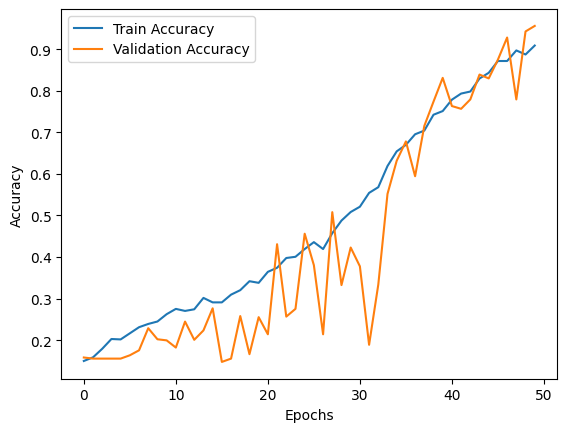

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
from tensorflow import keras

# Define the path to the model
model_path = "/kaggle/input/crick_classifier/keras/default/1/cricket_shot_classifier.h5"

# Load the model
model = keras.models.load_model(model_path)

# Verify the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 20, 75, 75, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20, 75, 75, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 37, 37, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 20, 37, 37, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 37, 37, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 18, 18, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 20, 18, 18, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 18, 18, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 10, 9, 9, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 10, 9, 9, 256)       │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 9, 9, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 5, 4, 4, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,430,921 (5.46 MB)

 Trainable params: 1,429,959 (5.45 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def predict_video(video_path):
    """ Extract frames from a test video and predict the shot type """
    frames = extract_frames(video_path)  # Use the same function as in training
    if frames is None:
        return "⚠️ No frames extracted for prediction"
    
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predictions = model.predict(frames)
    
    class_idx = np.argmax(predictions)
    confidence = np.max(predictions) * 100  # Get confidence percentage
    return shot_categories[class_idx], confidence


In [34]:
import cv2
import numpy as np

# ✅ Test the prediction
test_video_path = "/kaggle/working/dataset/test/sweep/13_rr_rcb_sweep_1.mp4"  # Update the path
predicted_shot, confidence = predict_video(test_video_path)

print(f"🏏 Predicted Shot Type: {predicted_shot} (Confidence: {confidence:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
🏏 Predicted Shot Type: sweep (Confidence: 99.31%)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


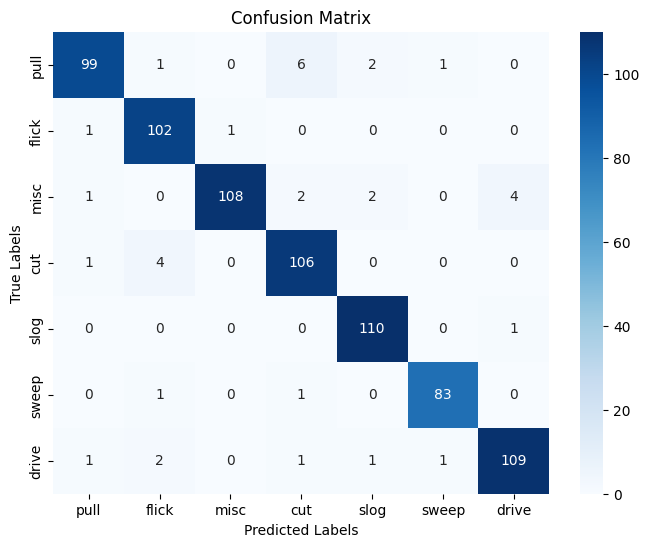


Classification Report:
               precision    recall  f1-score   support

        pull       0.96      0.91      0.93       109
       flick       0.93      0.98      0.95       104
        misc       0.99      0.92      0.96       117
         cut       0.91      0.95      0.93       111
        slog       0.96      0.99      0.97       111
       sweep       0.98      0.98      0.98        85
       drive       0.96      0.95      0.95       115

    accuracy                           0.95       752
   macro avg       0.95      0.95      0.95       752
weighted avg       0.95      0.95      0.95       752



In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Make Predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # True labels

# ✅ Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=shot_categories, yticklabels=shot_categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Step 3: Compute Classification Metrics
report = classification_report(y_true, y_pred, target_names=shot_categories)
print("\nClassification Report:\n", report)

In [36]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} — {layer.__class__.__name__}")

0: conv3d — Conv3D
1: batch_normalization — BatchNormalization
2: max_pooling3d — MaxPooling3D
3: conv3d_1 — Conv3D
4: batch_normalization_1 — BatchNormalization
5: max_pooling3d_1 — MaxPooling3D
6: conv3d_2 — Conv3D
7: batch_normalization_2 — BatchNormalization
8: max_pooling3d_2 — MaxPooling3D
9: conv3d_3 — Conv3D
10: batch_normalization_3 — BatchNormalization
11: max_pooling3d_3 — MaxPooling3D
12: global_average_pooling3d — GlobalAveragePooling3D
13: dense — Dense
14: dropout — Dropout
15: dense_1 — Dense
16: dropout_1 — Dropout
17: dense_2 — Dense


In [37]:
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def extract_motion_features(video_path, frame_count=20):
    """
    Extract motion intensity features from a cricket shot video
    using Optical Flow to detect bat movement timing.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"⚠️ Cannot open video: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, frame_count, dtype=int)

    prev_gray = None
    motion_features = []

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret or frame is None:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_gray is not None:
            # Compute dense optical flow
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            motion_intensity = np.mean(np.linalg.norm(flow, axis=2))
            motion_features.append(motion_intensity)

        prev_gray = gray

    cap.release()

    if len(motion_features) < frame_count - 1:
        print("⚠️ Not enough valid motion data.")
        return None

    return np.array(motion_features)

In [38]:
def compare_shot_timing(reference_path, target_path, threshold=0.85):
    """
    Compare cricket shot timing using optical flow and cosine similarity.
    - reference_path: best player's shot
    - target_path: video to be evaluated
    """
    print("🔄 Extracting motion features...")
    
    ref_features = extract_motion_features(reference_path)
    tgt_features = extract_motion_features(target_path)

    if ref_features is None or tgt_features is None:
        return "❌ Motion feature extraction failed."

    # Normalize and compute similarity
    ref_features /= np.linalg.norm(ref_features)
    tgt_features /= np.linalg.norm(tgt_features)
    sim_score = cosine_similarity([ref_features], [tgt_features])[0][0]

    print(f"✅ Shot Timing Similarity: {sim_score:.4f}")

    if sim_score > threshold:
        return f"👍 Excellent shot timing! Similarity: {sim_score:.2f}"
    elif sim_score > 0.75:
        return f"⚠️ Decent timing, but improve consistency. Similarity: {sim_score:.2f}"
    elif sim_score > 0.6:
        return f"⚠️ Work on shot execution speed. Try reacting earlier. Similarity: {sim_score:.2f}"
    else:
        return f"👎 Poor timing. Focus on reaction time and bat speed. Similarity: {sim_score:.2f}"


In [39]:
# Reference: best player’s shot
reference_video = "/kaggle/input/cosine/reference_shots/flick - Made with Clipchamp.mp4"

# Target: player’s current shot
target_video = "/kaggle/working/dataset/test/flick/15_dc_lsg_flick_1.mp4"

feedback = compare_shot_timing(reference_video, target_video, threshold=0.8)
print("📋 Feedback:", feedback)

🔄 Extracting motion features...
✅ Shot Timing Similarity: 0.8679
📋 Feedback: 👍 Excellent shot timing! Similarity: 0.87
